In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
import torchvision.transforms as transforms
#from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import tqdm
import copy

from torch.utils.data import DataLoader, Dataset


In [4]:
# model
# Defining a time-dependent score-based model

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, x_dim , hidden_depth=2, embed_dim=128, use_bn=True):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        self.x_dim = x_dim
        self.hidden_depth = hidden_depth
        self.embed_dim = embed_dim
        self.use_bn = use_bn

        assert hidden_depth>=1, 'hidden_depth must be greater than 0!'
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))

        # fc layers
        self.input = nn.Linear(x_dim, embed_dim)
        self.fc_all = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for i in range(self.hidden_depth)])
        self.output = nn.Linear(embed_dim, x_dim)

        if self.use_bn:
            self.bn = nn.ModuleList([nn.BatchNorm1d(num_features=embed_dim) for i in range(self.hidden_depth)])

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std


    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        #
        h = self.input(x)
        # residue connections
        for i in range(self.hidden_depth):
            h = h + self.act(self.fc_all[i](h)) + embed
            if self.use_bn:
                h = self.bn[i](h)

        h = self.output(h)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None,]
        return h


# Define the loss function
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps #(eps,1)
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=1))
    return loss


def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The standard deviation.
    """
    # t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))


def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    # return torch.tensor(sigma**t, device=device)
    return sigma**t


# data set
class MyDataset(Dataset):
    def __init__(self, x_train):
        super().__init__()
        self.x_train = x_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return self.x_train[idx]



def train_model(score_model, x_sample, lr=1e-4, batch_size=1000, n_epochs=5000, print_interval=100):
    dataset = MyDataset(x_sample)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = Adam(score_model.parameters(), lr=lr)
    train_loss = []


    for epoch in range(n_epochs):
        avg_loss = 0.
        num_items = 0
        for x in data_loader:
            x = x.to(device)
            loss = loss_fn(score_model, x, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
        # Print the averaged training loss so far.
        epoch_avg_loss = avg_loss / num_items
        train_loss.append(epoch_avg_loss)
        if epoch%print_interval==0:
            print(f'epoch: {epoch}\t loss: {epoch_avg_loss}')
    return train_loss


def Euler_Maruyama_sampler(score_prior, marginal_prob_std, diffusion_coeff, score_likelihood=None,
                           batch_size=64,num_steps=500,device='cpu',eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
    the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
    Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, score_prior.x_dim, device=device) \
    * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            if score_likelihood is None:
                score = score_prior(x, batch_time_step)
            else:
                score = score_prior(x, batch_time_step) + score_likelihood(x)*torch.relu(1-2*time_step)

            # score = torch.clip(score, min=-100, max=100)

            score_norm = torch.sqrt(torch.mean(score**2, dim=1))
            adj_ratio = torch.ones_like(score_norm)
            tol = 10.
            adj_ratio[score_norm>tol] = tol/score_norm[score_norm>tol]
            # score_norm = torch.clip(score_norm, min=0, max=50)


            score = score*adj_ratio[:,None]

            # print(time_step, score)

            mean_x = x + (g**2)[:, None] * score * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)
        # Do not include any noise in the last sampling step.
    return mean_x


In [7]:
# diffusion setup
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
sigma =  25.0 #@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)


In [14]:
# define obs score
def angle(x, obs_loc):
    x1 = x[:, 0]
    x2 = x[:, 1]
    angle = torch.arctan((x2-obs_loc[1]) / (x1-obs_loc[0]))
    return angle

def angle_np(x, obs_loc):
    x1 = x[:, 0]
    x2 = x[:, 1]
    angle = np.arctan((x2-obs_loc[1]) / (x1-obs_loc[0]))
    return angle


def angle_jac(x, obs_loc):
    numer = x-obs_loc
    numer = numer[:,[1,0]]
    numer[:,0] = -numer[:, 0]
    denom = torch.sum((x-obs_loc)**2, dim=1)

    return numer/denom[:, None]

def score_angle(x, theta, obs_loc, sigma_angle):
    temp1 = -(angle(x, obs_loc) - theta)/sigma_angle**2
    temp2 = angle_jac(x, obs_loc)
    score = temp2*temp1[:, None]

    # remove score near lob_loc
    tol = 0.5
    dist = torch.sqrt(torch.sum((x - obs_loc)**2, dim=1))
    score[dist<tol,:] = 0

    return score

def score_radius2(x, radius2, obs_loc, sigma_r):
    r2 = torch.sum((x - obs_loc)**2, dim=1)
    temp1 = -(r2 - radius2)/sigma_r**2
    temp2 = 2*(x - obs_loc)
    score = temp2*temp1[:, None]
    return score


# def my_likelihood(x, theta, sigma_angle, radius2, sigma_r, obs_locs):
#   theta1 = theta[0]
#   theta2 = theta[1]
#   obs_loc1, obs_loc2 = obs_locs
#   l1 = likelihood(x, theta1, obs_loc1, sigma)
#   l2 = likelihood(x, theta2, obs_loc2, sigma)
#   return l1*l2

def my_likelihood_score(x, theta, radius2, sigma_angle, sigma_r, obs_loc):
  score_1 = score_angle(x, theta, obs_loc, sigma_angle)
  score_2 = score_radius2(x, radius2, obs_loc, sigma_r)

  return score_1 + score_2*0 # only use the angle information



# filtering setup

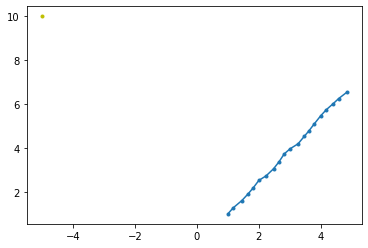

In [15]:
Time = 1
dt = 0.05
N_T = int(Time//dt+1)
t_path = np.linspace(0, Time, N_T)
X_initial = np.array([1, 1])
X_0 = X_initial
X_1 = np.zeros(2)
X_path = np.zeros((N_T, 2))
X_est = np.zeros((N_T, 2))
sigma_SDE = 0.2
num_dim=2

torch.manual_seed(1234567)
np.random.seed(1234567)

#R = 0.1
u1 = 4
u2 = 6
#obs_cov = R
num_steps = 100

obs_loc = np.array([-5,10])

X_path[0] = X_initial.copy()
#x_new = X_initial.copy()

for i in range(N_T-1):
    # Generate true state trajectory
    x_old = X_path[i].copy()
    x_new = np.zeros(2)

    x_new[0] = x_old[0] + u1 * dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)
    x_new[1] = x_old[1] + u2 * dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)

    X_path[i+1] = x_new

# plt.plot(*X_path.T, '.-',label='state')
#  plt.plot(*X_initial,'*',label='init')
#  plt.legend()
#  plt.title('state')

plt.plot(X_path[:,0], X_path[:,1],'.-')
plt.plot(*obs_loc,'y.')
plt.show()

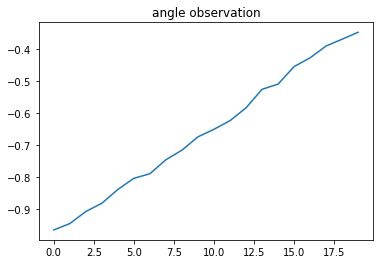

In [19]:
# get observation
sigma_obs_r = 0.1
sigma_obs_angle = 0.01

obs_angle = angle_np(X_path, obs_loc) # angle
obs_r2 = np.sum((X_path-obs_loc)**2, axis=1) # radius

obs1 = obs_angle + np.random.randn(N_T)*sigma_obs_angle
obs2 = obs_r2 + np.random.randn(N_T)*sigma_obs_r
obs_path = np.stack([obs1, obs2], axis = 1)



plt.plot(obs_path[:,0])
plt.title('angle observation')
plt.show()

# plt.plot(obs_path[:,1])
# plt.show()

In [34]:
# initial guess
x0 = torch.tensor(X_initial, dtype=torch.float32, device=device)
sigma0 = 0.5

obs_loc_t = torch.tensor(obs_loc,dtype=torch.float32, device=device)

In [35]:
# Training initialize
x_dim = num_dim
hidden_depth  = 2
embed_dim = 50
use_bn = False

score_prior_old = ScoreNet(marginal_prob_std=marginal_prob_std_fn, x_dim=x_dim,
                           hidden_depth=hidden_depth, embed_dim=embed_dim, use_bn=use_bn)

score_prior_new = ScoreNet(marginal_prob_std=marginal_prob_std_fn, x_dim=x_dim,
                           hidden_depth=hidden_depth, embed_dim=embed_dim, use_bn=use_bn)

score_prior_old = score_prior_old.to(device)
score_prior_new = score_prior_new.to(device)

# initial samples
sample_size = 1000
x_init = x0 + torch.randn(sample_size,num_dim, dtype=torch.float32, device=device)*sigma0
train_loss = train_model(score_prior_old, x_sample=x_init, batch_size=sample_size, lr=0.01, n_epochs=1000, print_interval=100)

likelihood_score_fn = None
likelihood_score_adj = None
score_prior_new = score_prior_old

epoch: 0	 loss: 3.6076183319091797
epoch: 100	 loss: 0.5719953775405884
epoch: 200	 loss: 0.5161183476448059
epoch: 300	 loss: 0.4296870231628418
epoch: 400	 loss: 0.4307054281234741
epoch: 500	 loss: 0.41820260882377625
epoch: 600	 loss: 0.41859665513038635
epoch: 700	 loss: 0.38471719622612
epoch: 800	 loss: 0.41924795508384705
epoch: 900	 loss: 0.43904992938041687


0


  0%|          | 0/500 [00:00<?, ?it/s]

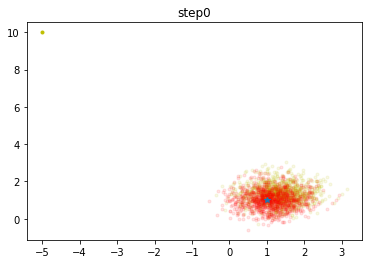

est:  [1.1197814 1.0404669]
state:  [1. 1.]
epoch: 0	 loss: 0.5149840116500854
epoch: 200	 loss: 0.41377732157707214
epoch: 400	 loss: 0.41973862051963806
epoch: 600	 loss: 0.4184325933456421
1


  0%|          | 0/500 [00:00<?, ?it/s]

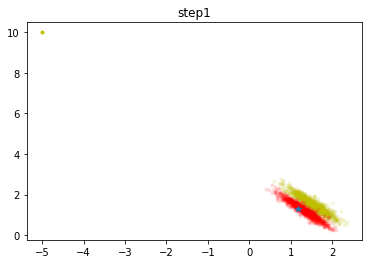

est:  [1.3119878 1.242086 ]
state:  [1.17698528 1.27989531]
epoch: 0	 loss: 0.33272573351860046
epoch: 200	 loss: 0.2567597031593323
epoch: 400	 loss: 0.2268425077199936
epoch: 600	 loss: 0.20218750834465027
2


  0%|          | 0/500 [00:00<?, ?it/s]

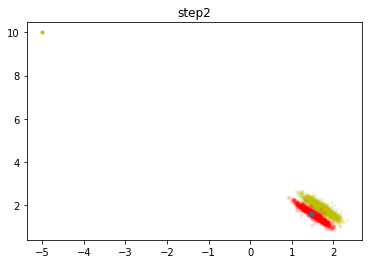

est:  [1.5146598 1.5920752]
state:  [1.45455991 1.60866815]
epoch: 0	 loss: 0.45261430740356445
epoch: 200	 loss: 0.15725183486938477
epoch: 400	 loss: 0.154990091919899
epoch: 600	 loss: 0.1624661386013031
3


  0%|          | 0/500 [00:00<?, ?it/s]

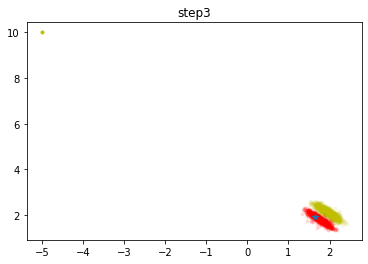

est:  [1.768035  1.8111392]
state:  [1.6557289 1.9122629]
epoch: 0	 loss: 0.3595868647098541
epoch: 200	 loss: 0.13117998838424683
epoch: 400	 loss: 0.10866298526525497
epoch: 600	 loss: 0.10668535530567169
4


  0%|          | 0/500 [00:00<?, ?it/s]

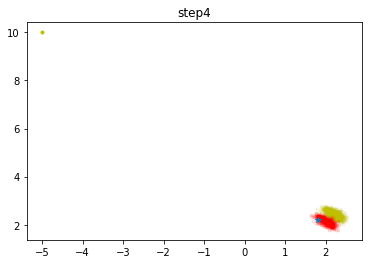

est:  [1.9985619 2.143354 ]
state:  [1.82006858 2.18417402]
epoch: 0	 loss: 0.48616689443588257
epoch: 200	 loss: 0.06892010569572449
epoch: 400	 loss: 0.07051537930965424
epoch: 600	 loss: 0.08480562269687653
5


  0%|          | 0/500 [00:00<?, ?it/s]

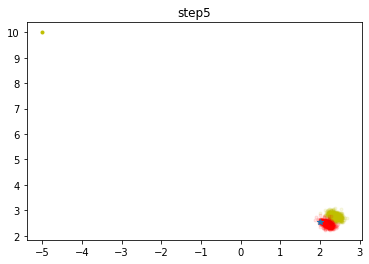

est:  [2.1663337 2.4722774]
state:  [2.00458482 2.52746809]
epoch: 0	 loss: 0.34348106384277344
epoch: 200	 loss: 0.06092328205704689
epoch: 400	 loss: 0.049401383846998215
epoch: 600	 loss: 0.041651368141174316
6


  0%|          | 0/500 [00:00<?, ?it/s]

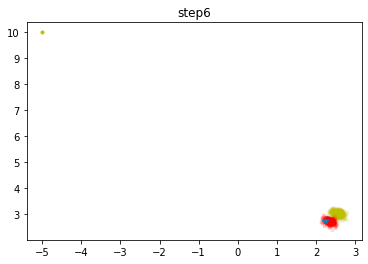

est:  [2.3509474 2.7235522]
state:  [2.23614099 2.73101768]
epoch: 0	 loss: 0.25498947501182556
epoch: 200	 loss: 0.039101485162973404
epoch: 400	 loss: 0.04536307975649834
epoch: 600	 loss: 0.03377074748277664
7


  0%|          | 0/500 [00:00<?, ?it/s]

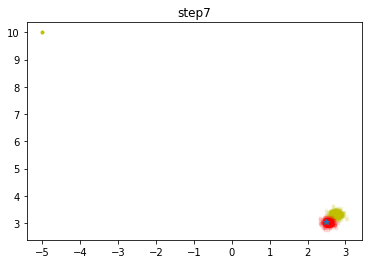

est:  [2.5423915 3.0285714]
state:  [2.47865309 3.0550862 ]
epoch: 0	 loss: 0.3005230724811554
epoch: 200	 loss: 0.04579702392220497
epoch: 400	 loss: 0.03315439820289612
epoch: 600	 loss: 0.03909451887011528
8


  0%|          | 0/500 [00:00<?, ?it/s]

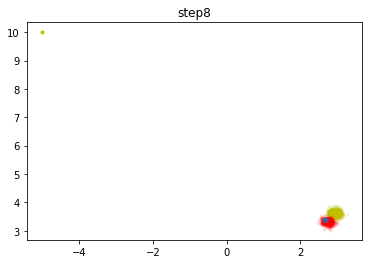

est:  [2.7445757 3.3222473]
state:  [2.65849301 3.37972017]
epoch: 0	 loss: 0.28565147519111633
epoch: 200	 loss: 0.038659028708934784
epoch: 400	 loss: 0.043989915400743484
epoch: 600	 loss: 0.04196237400174141
9


  0%|          | 0/500 [00:00<?, ?it/s]

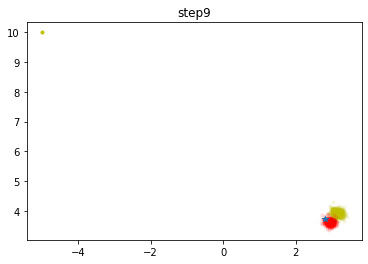

est:  [2.9439192 3.6259494]
state:  [2.8245243  3.73444838]
epoch: 0	 loss: 0.39090314507484436
epoch: 200	 loss: 0.033574849367141724
epoch: 400	 loss: 0.036939479410648346
epoch: 600	 loss: 0.0427623987197876
10


  0%|          | 0/500 [00:00<?, ?it/s]

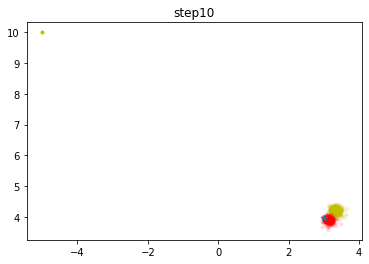

est:  [3.1286783 3.9038556]
state:  [3.0173769  3.96934094]
epoch: 0	 loss: 0.27009472250938416
epoch: 200	 loss: 0.0373721644282341
epoch: 400	 loss: 0.05223521590232849
epoch: 600	 loss: 0.04667961969971657
11


  0%|          | 0/500 [00:00<?, ?it/s]

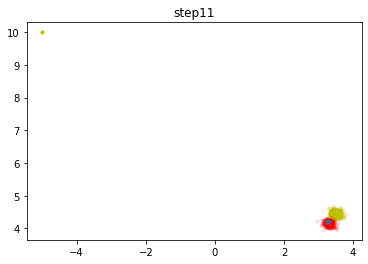

est:  [3.28796  4.150158]
state:  [3.27142372 4.1923519 ]
epoch: 0	 loss: 0.263526976108551
epoch: 200	 loss: 0.036883193999528885
epoch: 400	 loss: 0.05105471611022949
epoch: 600	 loss: 0.052944399416446686
12


  0%|          | 0/500 [00:00<?, ?it/s]

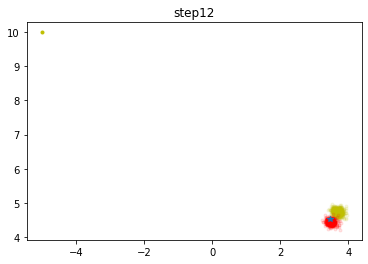

est:  [3.4780772 4.4351916]
state:  [3.47116002 4.53127264]
epoch: 0	 loss: 0.31229639053344727
epoch: 200	 loss: 0.03803982213139534
epoch: 400	 loss: 0.043729037046432495
epoch: 600	 loss: 0.04308738932013512
13


  0%|          | 0/500 [00:00<?, ?it/s]

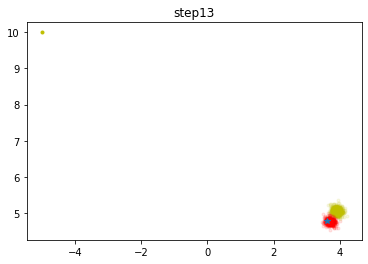

est:  [3.703529  4.7535086]
state:  [3.61456308 4.76844678]
epoch: 0	 loss: 0.570848822593689
epoch: 200	 loss: 0.042615022510290146
epoch: 400	 loss: 0.03807288408279419
epoch: 600	 loss: 0.035991962999105453
14


  0%|          | 0/500 [00:00<?, ?it/s]

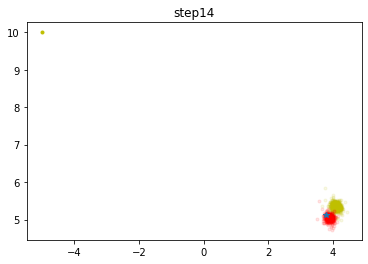

est:  [3.899281  5.0502863]
state:  [3.80116745 5.11149938]
epoch: 0	 loss: 0.35849565267562866
epoch: 200	 loss: 0.040415048599243164
epoch: 400	 loss: 0.047123342752456665
epoch: 600	 loss: 0.03657212853431702
15


  0%|          | 0/500 [00:00<?, ?it/s]

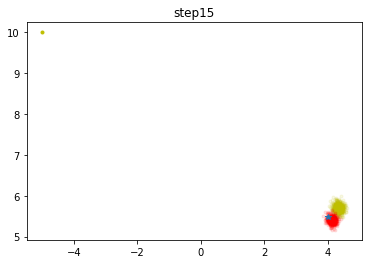

est:  [4.1348524 5.399629 ]
state:  [4.00663525 5.47421166]
epoch: 0	 loss: 0.4431762397289276
epoch: 200	 loss: 0.04674992710351944
epoch: 400	 loss: 0.03879544883966446
epoch: 600	 loss: 0.0456591360270977
16


  0%|          | 0/500 [00:00<?, ?it/s]

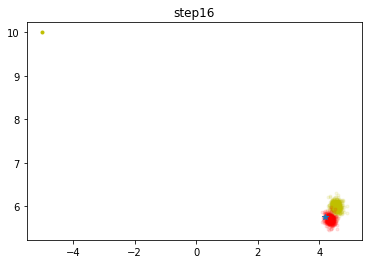

est:  [4.345426  5.7011213]
state:  [4.18445014 5.74587967]
epoch: 0	 loss: 0.33701181411743164
epoch: 200	 loss: 0.04694424569606781
epoch: 400	 loss: 0.044114790856838226
epoch: 600	 loss: 0.05664306506514549
17


  0%|          | 0/500 [00:00<?, ?it/s]

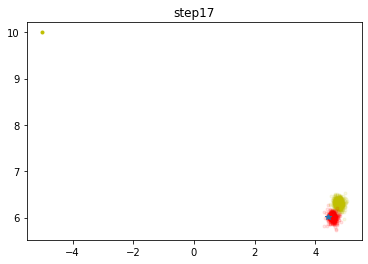

est:  [4.5620456 6.013437 ]
state:  [4.40080866 6.01208084]
epoch: 0	 loss: 0.4248988926410675
epoch: 200	 loss: 0.0452410988509655
epoch: 400	 loss: 0.04706637188792229
epoch: 600	 loss: 0.05100365728139877
18


  0%|          | 0/500 [00:00<?, ?it/s]

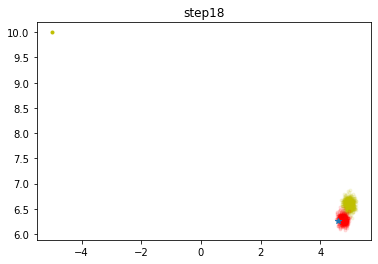

est:  [4.765337  6.2945085]
state:  [4.58201302 6.25096009]
epoch: 0	 loss: 0.33316749334335327
epoch: 200	 loss: 0.03984798491001129
epoch: 400	 loss: 0.052885960787534714
epoch: 600	 loss: 0.041123416274785995


  0%|          | 0/500 [00:00<?, ?it/s]

In [36]:
est_all = []
x_prior = x_init.clone()
for i in range(N_T-1):
    print(i)
    
    score_prior_old = score_prior_new
    score_prior_new = copy.deepcopy(score_prior_new)
    
    # sample initial distribution
    x_init = Euler_Maruyama_sampler(score_prior_old,marginal_prob_std_fn, diffusion_coeff_fn,score_likelihood=likelihood_score_adj,
                                   batch_size=sample_size,num_steps=500,device=device)

    est_all.append(torch.mean(x_init, dim=0).cpu().numpy())

    
    x_prior[:,0] = x_init[:,0] + u1*dt + torch.randn(sample_size,device=device) * np.sqrt(dt) * sigma_SDE
    x_prior[:,1] = x_init[:,1] + u2*dt + torch.randn(sample_size,device=device) * np.sqrt(dt) * sigma_SDE
      
#     # solve for forward SDE (prediction)
#     x_prior = x_init + dt*torch.tensor([u, 2*u], dtype=torch.float32, device=device) + np.sqrt(dt)*sigma_SDE*torch.randn_like(x_init)

    plt.plot(*x_prior.cpu().T,'y.',alpha=0.1,label='prior')
    plt.plot(*x_init.cpu().T,'r.',alpha=0.1,label='initial')
    plt.plot(*X_path[i],'*')
    plt.plot(*obs_loc,'y.')
    plt.title(f'step{i}')
    plt.show()

    
    print('est: ',est_all[i])
    print('state: ',X_path[i])

    # train model for prior distribution
    train_loss = train_model(score_prior_new, x_sample=x_prior,
                             batch_size=sample_size,lr=0.01, n_epochs=800, print_interval=200)

    # new observation
    #obs_current = torch.from_numpy(obs_path[i+1,:]).float().to(device)
    temp_theta,temp_r2 = obs_path[i+1,:]
    # update likelihood function

    likelihood_score_fn = functools.partial(my_likelihood_score, theta=temp_theta, radius2=temp_r2,
                                            sigma_angle=sigma_obs_angle, sigma_r=sigma_obs_r, obs_loc=obs_loc_t)


    # Gaussian regularization
    prior_mean = torch.mean(x_prior, dim=0)
    prior_std = torch.std(x_prior, dim=0)
    def reg_gaussian(x, mu, sigma):
        score_gaussian = -(x-mu)/sigma**2
        score_gaussian_sign = torch.sign(score_gaussian)
        score_gaussian_abs = torch.abs(score_gaussian)
        tol = 4
        score_gaussian_abs = torch.relu(score_gaussian_abs - tol)
        return score_gaussian_sign*score_gaussian_abs
    reg_score_fn = functools.partial(reg_gaussian, mu=prior_mean, sigma=prior_std)

    def likelihood_score_adj(x,l=likelihood_score_fn,reg=reg_score_fn):
        return l(x) + reg(x)
    # next iteration

# last estimation
# sample initial distribution
x_init = Euler_Maruyama_sampler(score_prior_old,marginal_prob_std_fn, diffusion_coeff_fn,score_likelihood=likelihood_score_adj,
                               batch_size=sample_size,num_steps=500,device=device)
est_all.append(torch.mean(x_init, dim=0).cpu().numpy())

est_all = np.array(est_all)



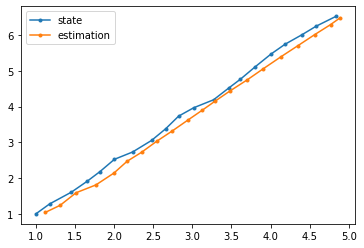

In [37]:
plt.plot(*X_path.T,'.-',label='state')
plt.plot(*est_all.T,'.-',label ='estimation')
plt.legend()
plt.show()

In [ ]:
np.savetxt('Est_all.txt', est_all)
np.savetxt('X_path.txt', X_path)
np.savetxt('obs_path.txt', obs_path)